# Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [2]:
from base import gc_collect_all, setdiff
from filesystem_utils import mkdir
from graph import abline
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [3]:
gc_collect_all()

In [4]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [5]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [6]:
import os
os.getcwd()

'/Volumes/KHJ/Github/hyuckjinkim/data-scientist-competitions/Dacon/19_추석선물수요량예측'

In [7]:
mkdir(['./out','./mc'])

<br></br>

# Configuration

In [8]:
class CFG:
    TARGET = '수요량'
    
    # feature engineering
    SUBSET_DEPTH = 3
    TARGET_TRANSFORMATION = 'log' # 'identity','log'
    
    # kfold
    SEED = 0
    N_SPLITS = 5

<br></br>

# Data Load

In [9]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [10]:
train_df.head()

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량
0,TRAIN_0000,1,쇼핑몰 15,212000,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일선물세트,28
1,TRAIN_0001,2,쇼핑몰 72,113000,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼선물세트,27
2,TRAIN_0002,0,쇼핑몰 15,67000,0,도시 6,지역 1,쇼핑몰 유형 2,실속스팸선물세트,769
3,TRAIN_0003,1,쇼핑몰 13,206000,0,도시 12,지역 3,쇼핑몰 유형 1,자연산프리미엄버섯선물세트,27
4,TRAIN_0004,1,쇼핑몰 65,140000,0,도시 16,지역 2,쇼핑몰 유형 2,자연산새우선물세트,337


<br></br>

# EDA

In [11]:
unuse_features = ['ID']
cat_features = ['추석까지 남은 기간(주)','쇼핑몰 구분','도시 유형','지역 유형','쇼핑몰 유형','선물 유형']
num_features = ['가격(원)']
dummy_features = ['프로모션 여부']

In [12]:
train_df[cat_features+dummy_features].nunique()

추석까지 남은 기간(주)     3
쇼핑몰 구분           77
도시 유형            24
지역 유형             8
쇼핑몰 유형            3
선물 유형            51
프로모션 여부           2
dtype: int64

In [13]:
display(train_df.isnull().sum())
display(test_df.isnull().sum())

ID               0
추석까지 남은 기간(주)    0
쇼핑몰 구분           0
가격(원)            0
프로모션 여부          0
도시 유형            0
지역 유형            0
쇼핑몰 유형           0
선물 유형            0
수요량              0
dtype: int64

ID               0
추석까지 남은 기간(주)    0
쇼핑몰 구분           0
가격(원)            0
프로모션 여부          0
도시 유형            0
지역 유형            0
쇼핑몰 유형           0
선물 유형            0
dtype: int64

<br>

## target

In [14]:
def histplot_with_boxplot_above(x)->None:
    f, (ax_box, ax_hist) = plt.subplots(2,figsize=(15,7),sharex=True,gridspec_kw={"height_ratios":(.15,.85)})

    ax_box = sns.boxplot(x=x, ax=ax_box)
    ax_box.set_xlabel('')
    ax_hist = sns.histplot(x, kde=True, stat='density', ax=ax_hist)
    ax_hist.grid()

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.show()

In [15]:
train_df[CFG.TARGET].describe()

count    5872.000000
mean      264.313692
std       338.789214
min        13.000000
25%        54.000000
50%       136.000000
75%       350.000000
max      4455.000000
Name: 수요량, dtype: float64

In [16]:
train_df.head()

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량
0,TRAIN_0000,1,쇼핑몰 15,212000,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일선물세트,28
1,TRAIN_0001,2,쇼핑몰 72,113000,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼선물세트,27
2,TRAIN_0002,0,쇼핑몰 15,67000,0,도시 6,지역 1,쇼핑몰 유형 2,실속스팸선물세트,769
3,TRAIN_0003,1,쇼핑몰 13,206000,0,도시 12,지역 3,쇼핑몰 유형 1,자연산프리미엄버섯선물세트,27
4,TRAIN_0004,1,쇼핑몰 65,140000,0,도시 16,지역 2,쇼핑몰 유형 2,자연산새우선물세트,337


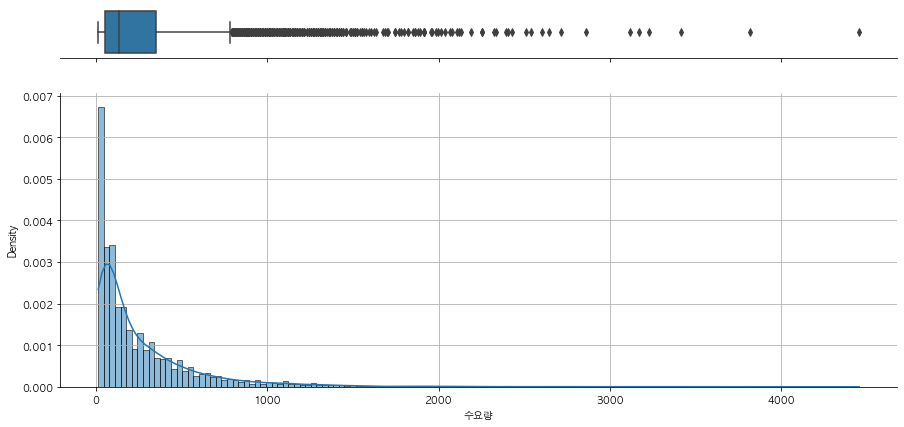

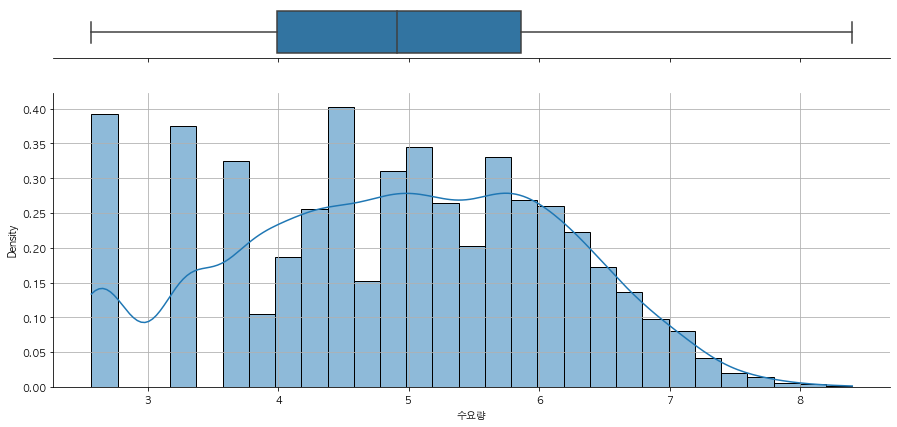

In [17]:
histplot_with_boxplot_above(train_df[CFG.TARGET])
histplot_with_boxplot_above(np.log(train_df[CFG.TARGET]))

<br>

## numeric 1D

feature vs target scatterplot

In [18]:
# # 같은 가격인데도 수요량은 많이 다름
# plt.figure(figsize=(15,7))
# sns.scatterplot(x=train_df['가격(원)'],y=train_df[CFG.TARGET])
# plt.grid()
# plt.show()

<br>

## categogical 1D

In [19]:
# 테스트셋에만 존재하는 값은 없음
for col in cat_features+dummy_features:
    test_only_value = setdiff(test_df[col].unique(),train_df[col].unique())
    if len(test_only_value)>0:
        print('Exist only in test dataset. {}: {} values'.format(col,len(test_only_value)))

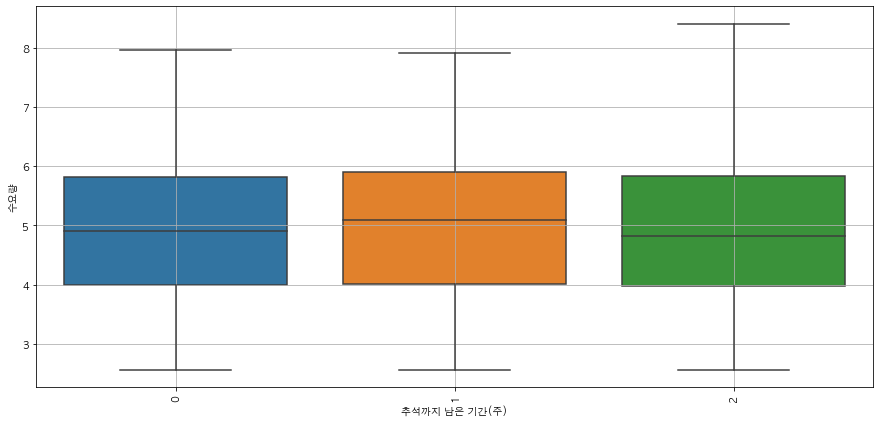

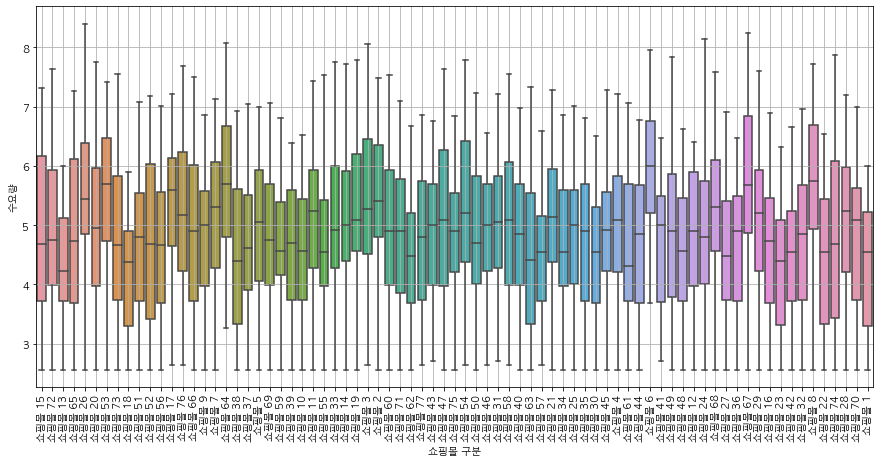

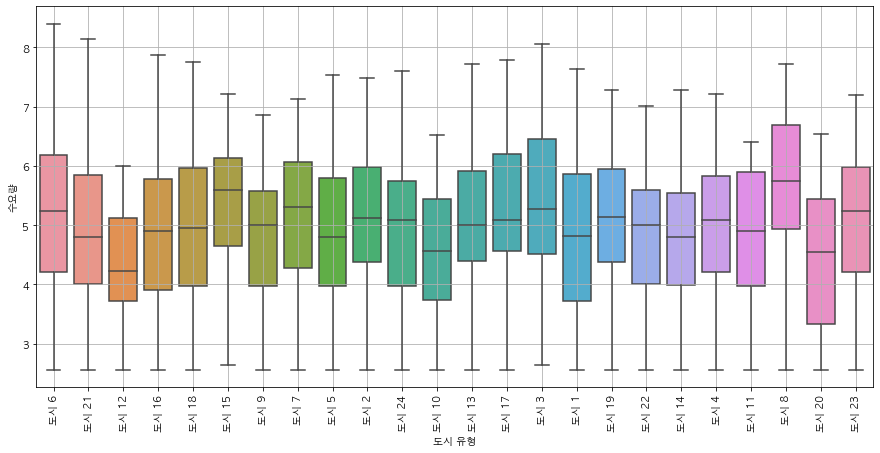

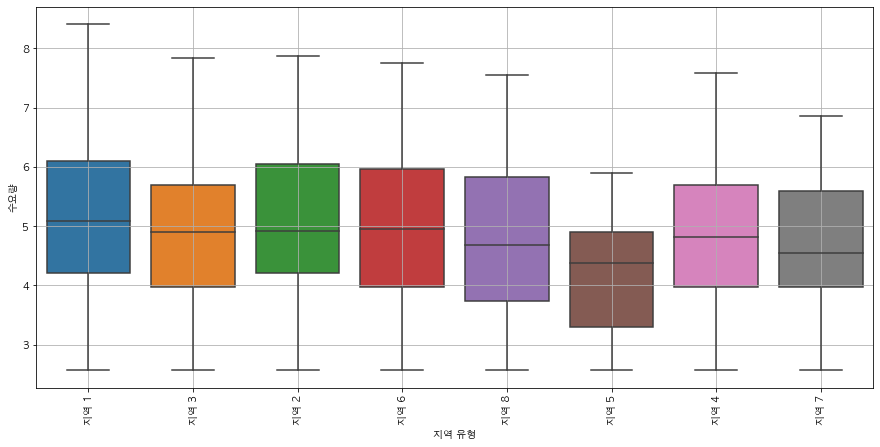

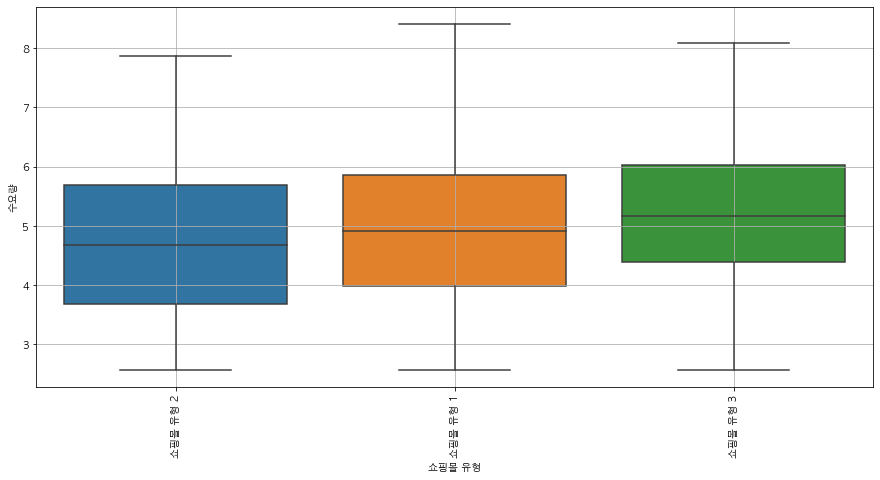

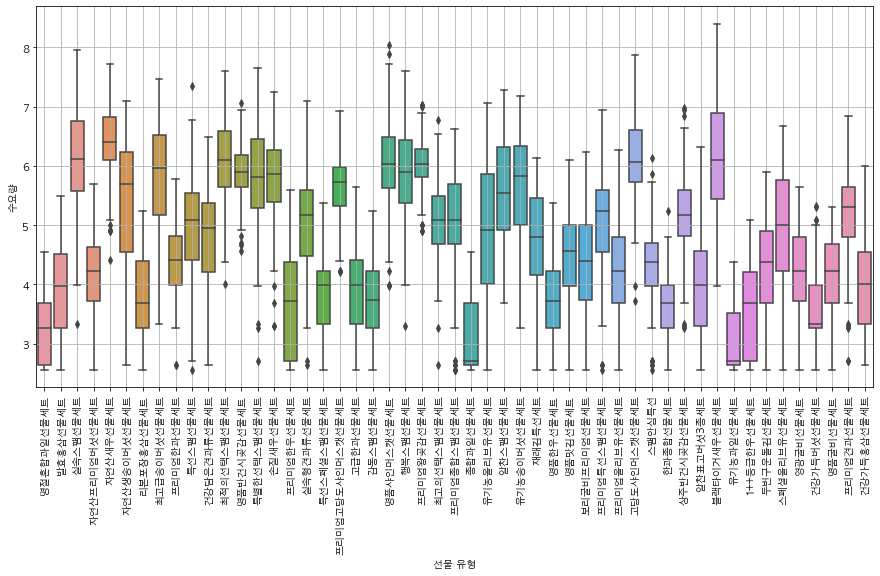

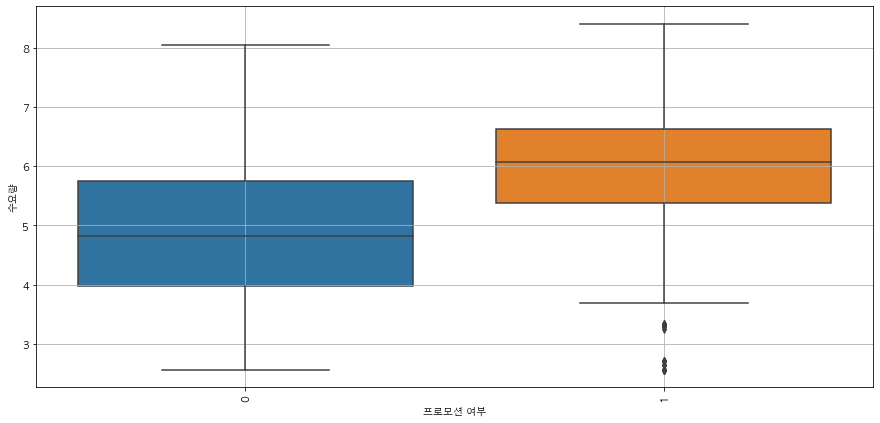

In [20]:
y = np.log(train_df[CFG.TARGET])
for col in cat_features+dummy_features:
    plt.figure(figsize=(15,7))
    sns.boxplot(x=train_df[col],y=y)
    plt.grid()
    plt.xticks(rotation=90)
    plt.show()

<br></br>

# Make Segment

In [21]:
# segment_feature = 'segment'
segment_feature = None

In [22]:
if segment_feature=='segment':
    segment_features = ['선물 유형','프로모션 여부']
    train_df['segment'] = ['_'.join(x) for x in train_df[segment_features].astype(str).values]
    test_df ['segment'] = ['_'.join(x) for x in test_df [segment_features].astype(str).values]

    # 테스트셋에만 존재하는 값이 있는지 확인
    print(setdiff(test_df['segment'].unique(),train_df['segment'].unique()))

    # segment freq 확인
    display(train_df['segment'].value_counts())

    # segment별 target의 boxplot 확인
    x = train_df['segment']
    y = np.log(train_df[CFG.TARGET])

    plt.figure(figsize=(15,7))
    sns.boxplot(x=x,y=y)
    plt.grid()
    plt.xticks(rotation=90)
    plt.show()
else:
    segment_features = []

<br></br>

# Data Preprocess

## Derived Features

In [23]:
def derived_features(data):
    d = data.copy()
    return d

In [24]:
train_df1 = derived_features(train_df)
test_df1  = derived_features(test_df)

type_controller = TypeController(
    unuse_features=unuse_features+segment_features,
    target_feature=CFG.TARGET,
    cat_features=cat_features,
    segment_feature=segment_feature,
)
type_controller.fit(train_df1)
global_assignment(type_controller.get_feature_type())

train_df1 = type_controller.transform(train_df1)
test_df1  = type_controller.transform(test_df1)

In [25]:
type_controller.get_feature_type()

{'target_feature': '수요량',
 'unuse_features': ['ID'],
 'dummy_features': ['프로모션 여부'],
 'cat_features': ['추석까지 남은 기간(주)',
  '쇼핑몰 구분',
  '도시 유형',
  '지역 유형',
  '쇼핑몰 유형',
  '선물 유형'],
 'num_features': ['가격(원)'],
 'segment_feature': None}

In [26]:
train_df1.head()

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량
0,TRAIN_0000,1,쇼핑몰 15,212000.0,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일선물세트,28
1,TRAIN_0001,2,쇼핑몰 72,113000.0,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼선물세트,27
2,TRAIN_0002,0,쇼핑몰 15,67000.0,0,도시 6,지역 1,쇼핑몰 유형 2,실속스팸선물세트,769
3,TRAIN_0003,1,쇼핑몰 13,206000.0,0,도시 12,지역 3,쇼핑몰 유형 1,자연산프리미엄버섯선물세트,27
4,TRAIN_0004,1,쇼핑몰 65,140000.0,0,도시 16,지역 2,쇼핑몰 유형 2,자연산새우선물세트,337


In [27]:
test_df1.head()

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형
0,TEST_0000,2,쇼핑몰 71,113000.0,0,도시 16,지역 3,쇼핑몰 유형 1,상주반건시곶감선물세트
1,TEST_0001,0,쇼핑몰 57,224000.0,0,도시 6,지역 1,쇼핑몰 유형 2,고급한과선물세트
2,TEST_0002,2,쇼핑몰 38,150000.0,0,도시 16,지역 1,쇼핑몰 유형 2,최고의선택스팸선물세트
3,TEST_0003,1,쇼핑몰 50,132000.0,0,도시 16,지역 3,쇼핑몰 유형 1,재래김특선세트
4,TEST_0004,0,쇼핑몰 55,146000.0,0,도시 5,지역 4,쇼핑몰 유형 2,명품샤인머스캣선물세트


<br>

## Imputation

In [28]:
train_df2 = train_df1.copy()
test_df2  = test_df1 .copy()

In [29]:
def check_null(data):
    d = data.copy()

    null_info = train_df2\
        .isnull().sum()\
        .reset_index()\
        .rename(columns={'index':'feature',0:'null_cnt'})

    null_info = null_info[null_info['null_cnt']!=0]
    null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(train_df)
    null_info = null_info.sort_values('null_cnt',ascending=False)
    
    if len(null_info)==0:
        return None
    else:
        return null_info

In [30]:
check_null(train_df2),check_null(test_df2)

(None, None)

In [31]:
# from sklearn.impute import SimpleImputer

# impute_columns = []
# imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# train_df2[impute_columns] = imputer.fit_transform(train_df2[impute_columns])
# test_df2 [impute_columns] = imputer.transform(test_df2[impute_columns])

In [32]:
# check_null(train_df2),check_null(test_df2)

<br>

## Target Transformation

In [33]:
CFG.TARGET_TRANSFORMATION

'log'

In [34]:
train_df3 = train_df2.copy()
test_df3  = test_df2 .copy()

target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION)
train_df3[CFG.TARGET] = target_transform.fit_transform(
    target=train_df3[CFG.TARGET],
)

<AxesSubplot: ylabel='수요량'>

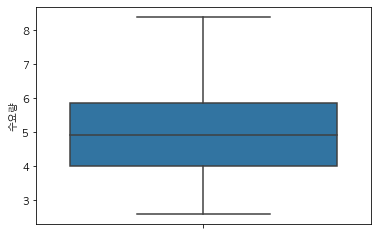

In [35]:
sns.boxplot(y=train_df3[CFG.TARGET])

<br>

## Quantile values of Target

In [36]:
cat_features

['추석까지 남은 기간(주)', '쇼핑몰 구분', '도시 유형', '지역 유형', '쇼핑몰 유형', '선물 유형']

In [37]:
# feature engineering
calculator = CategoricalQuantileCalculator()
calculator.fit(
    data=train_df3,
    test_data=test_df3,
    target_feature=target_feature,
    cat_features=cat_features,
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df4 = calculator.transform(train_df3)
test_df4  = calculator.transform(test_df3)

> Get quantiles of target by categorical features (depth=3)


Subset: 도시 유형 + 지역 유형 + 쇼핑몰 유형: 100%|██████████| 41/41 [00:04<00:00,  9.90it/s]             


In [38]:
type_controller = TypeController(
    unuse_features=unuse_features+segment_features,
    target_feature=CFG.TARGET,
    cat_features=cat_features,
    segment_feature=segment_feature,
)
type_controller.fit(train_df4)
global_assignment(type_controller.get_feature_type())

train_df4 = type_controller.transform(train_df4)
test_df4  = type_controller.transform(test_df4)

In [39]:
print(train_df3.shape,'->',train_df4.shape)
train_df4.head()

(5872, 10) -> (5872, 122)


,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량,추석까지 남은 기간(주)_Avg,추석까지 남은 기간(주)_Q25,추석까지 남은 기간(주)_Q50,추석까지 남은 기간(주)_Q75,쇼핑몰 구분_Avg,쇼핑몰 구분_Q25,쇼핑몰 구분_Q50,쇼핑몰 구분_Q75,도시 유형_Avg,도시 유형_Q25,도시 유형_Q50,도시 유형_Q75,지역 유형_Avg,지역 유형_Q25,지역 유형_Q50,지역 유형_Q75,쇼핑몰 유형_Avg,쇼핑몰 유형_Q25,쇼핑몰 유형_Q50,쇼핑몰 유형_Q75,선물 유형_Avg,선물 유형_Q25,선물 유형_Q50,선물 유형_Q75,추석까지 남은 기간(주)&쇼핑몰 구분_Avg,추석까지 남은 기간(주)&쇼핑몰 구분_Q25,추석까지 남은 기간(주)&쇼핑몰 구분_Q50,추석까지 남은 기간(주)&쇼핑몰 구분_Q75,추석까지 남은 기간(주)&도시 유형_Avg,추석까지 남은 기간(주)&도시 유형_Q25,추석까지 남은 기간(주)&도시 유형_Q50,추석까지 남은 기간(주)&도시 유형_Q75,추석까지 남은 기간(주)&지역 유형_Avg,추석까지 남은 기간(주)&지역 유형_Q25,추석까지 남은 기간(주)&지역 유형_Q50,추석까지 남은 기간(주)&지역 유형_Q75,추석까지 남은 기간(주)&쇼핑몰 유형_Avg,추석까지 남은 기간(주)&쇼핑몰 유형_Q25,추석까지 남은 기간(주)&쇼핑몰 유형_Q50,추석까지 남은 기간(주)&쇼핑몰 유형_Q75,추석까지 남은 기간(주)&선물 유형_Avg,추석까지 남은 기간(주)&선물 유형_Q25,추석까지 남은 기간(주)&선물 유형_Q50,추석까지 남은 기간(주)&선물 유형_Q75,쇼핑몰 구분&도시 유형_Avg,쇼핑몰 구분&도시 유형_Q25,쇼핑몰 구분&도시 유형_Q50,쇼핑몰 구분&도시 유형_Q75,쇼핑몰 구분&지역 유형_Avg,쇼핑몰 구분&지역 유형_Q25,쇼핑몰 구분&지역 유형_Q50,쇼핑몰 구분&지역 유형_Q75,쇼핑몰 구분&쇼핑몰 유형_Avg,쇼핑몰 구분&쇼핑몰 유형_Q25,쇼핑몰 구분&쇼핑몰 유형_Q50,쇼핑몰 구분&쇼핑몰 유형_Q75,도시 유형&지역 유형_Avg,도시 유형&지역 유형_Q25,도시 유형&지역 유형_Q50,도시 유형&지역 유형_Q75,도시 유형&쇼핑몰 유형_Avg,도시 유형&쇼핑몰 유형_Q25,도시 유형&쇼핑몰 유형_Q50,도시 유형&쇼핑몰 유형_Q75,지역 유형&쇼핑몰 유형_Avg,지역 유형&쇼핑몰 유형_Q25,지역 유형&쇼핑몰 유형_Q50,지역 유형&쇼핑몰 유형_Q75,쇼핑몰 유형&선물 유형_Avg,쇼핑몰 유형&선물 유형_Q25,쇼핑몰 유형&선물 유형_Q50,쇼핑몰 유형&선물 유형_Q75,추석까지 남은 기간(주)&쇼핑몰 구분&도시 유형_Avg,추석까지 남은 기간(주)&쇼핑몰 구분&도시 유형_Q25,추석까지 남은 기간(주)&쇼핑몰 구분&도시 유형_Q50,추석까지 남은 기간(주)&쇼핑몰 구분&도시 유형_Q75,추석까지 남은 기간(주)&쇼핑몰 구분&지역 유형_Avg,추석까지 남은 기간(주)&쇼핑몰 구분&지역 유형_Q25,추석까지 남은 기간(주)&쇼핑몰 구분&지역 유형_Q50,추석까지 남은 기간(주)&쇼핑몰 구분&지역 유형_Q75,추석까지 남은 기간(주)&쇼핑몰 구분&쇼핑몰 유형_Avg,추석까지 남은 기간(주)&쇼핑몰 구분&쇼핑몰 유형_Q25,추석까지 남은 기간(주)&쇼핑몰 구분&쇼핑몰 유형_Q50,추석까지 남은 기간(주)&쇼핑몰 구분&쇼핑몰 유형_Q75,추석까지 남은 기간(주)&도시 유형&지역 유형_Avg,추석까지 남은 기간(주)&도시 유형&지역 유형_Q25,추석까지 남은 기간(주)&도시 유형&지역 유형_Q50,추석까지 남은 기간(주)&도시 유형&지역 유형_Q75,추석까지 남은 기간(주)&도시 유형&쇼핑몰 유형_Avg,추석까지 남은 기간(주)&도시 유형&쇼핑몰 유형_Q25,추석까지 남은 기간(주)&도시 유형&쇼핑몰 유형_Q50,추석까지 남은 기간(주)&도시 유형&쇼핑몰 유형_Q75,추석까지 남은 기간(주)&지역 유형&쇼핑몰 유형_Avg,추석까지 남은 기간(주)&지역 유형&쇼핑몰 유형_Q25,추석까지 남은 기간(주)&지역 유형&쇼핑몰 유형_Q50,추석까지 남은 기간(주)&지역 유형&쇼핑몰 유형_Q75,쇼핑몰 구분&도시 유형&지역 유형_Avg,쇼핑몰 구분&도시 유형&지역 유형_Q25,쇼핑몰 구분&도시 유형&지역 유형_Q50,쇼핑몰 구분&도시 유형&지역 유형_Q75,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Avg,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q25,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q50,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q75,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Avg,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q25,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q50,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q75,도시 유형&지역 유형&쇼핑몰 유형_Avg,도시 유형&지역 유형&쇼핑몰 유형_Q25,도시 유형&지역 유형&쇼핑몰 유형_Q50,도시 유형&지역 유형&쇼핑몰 유형_Q75
0,TRAIN_0000,1,쇼핑몰 15,212000.0,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일선물세트,3.332205,4.992657,4.007333,5.093750,5.902633,4.873879,3.713572,4.686740,6.172463,5.184096,4.204693,5.241747,6.186209,5.080529,4.204693,5.093750,6.098074,4.641414,3.688879,4.682131,5.693732,3.184714,2.639057,3.258097,3.688879,4.655161,3.332205,4.204693,6.186209,5.235991,4.234107,5.310737,6.255022,5.197724,4.234107,5.308268,6.216606,4.698601,3.688879,4.795791,5.736572,3.316893,2.708050,3.295837,3.713572,4.873879,3.713572,4.686740,6.172463,4.873879,3.713572,4.686740,6.172463,4.873879,3.713572,4.686740,6.172463,5.184096,4.204693,5.241747,6.186209,4.625334,3.713572,4.553877,5.715152,4.611669,3.688879,4.564348,5.739793,2.996248,2.620530,2.948577,3.276624,4.655161,3.332205,4.204693,6.186209,4.655161,3.332205,4.204693,6.186209,4.655161,3.332205,4.204693,6.186209,5.235991,4.234107,5.310737,6.255022,4.627774,3.599711,4.618004,5.757450,4.675366,3.688879,4.682131,5.857933,4.873879,3.713572,4.686740,6.172463,4.873879,3.713572,4.686740,6.172463,4.873879,3.713572,4.686740,6.172463,4.625334,3.713572,4.553877,5.715152
1,TRAIN_0001,2,쇼핑몰 72,113000.0,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼선물세트,3.295837,4.839308,3.970292,4.812184,5.826000,4.923296,3.988984,4.751766,5.935555,4.876896,4.007333,4.795791,5.840490,5.080529,4.204693,5.093750,6.098074,4.914641,3.988984,4.912655,5.857933,3.877076,3.267532,3.970292,4.509151,4.902553,3.988984,4.691348,6.003887,4.805002,3.970292,4.564348,5.860786,4.933738,3.970292,4.905275,5.932245,4.856061,3.970292,4.804021,5.857933,3.401927,3.258097,3.332205,3.688879,4.923296,3.988984,4.7

<br>

## Group Scaler

In [40]:
if segment_feature is not None:
    from sklearn.preprocessing import MinMaxScaler
    scaler = GroupScaler(scaler=MinMaxScaler())
    scaler.fit(
        data=train_df4,
        group=segment_feature,
        num_features=num_features,
    )
    train_df5 = scaler.transform(train_df4)
    test_df5  = scaler.transform(test_df4)
else:
    train_df5 = train_df4.copy()
    test_df5  = test_df4 .copy()

In [41]:
# from sklearn.preprocessing import MinMaxScaler

# group = ['선물 유형'] # '선물 유형', '쇼핑몰 구분'
# scaler = GroupScaler(scaler=MinMaxScaler())
# scaler.fit(
#     data=train_df4,
#     group=group,
#     num_features=num_features,
# )
# train_df5 = scaler.transform(train_df4)
# test_df5  = scaler.transform(test_df4)

<br>

## Memory Reduce

In [42]:
train_df6, _ = reduce_mem_usage(train_df5,verbose=False)
test_df6 , _ = reduce_mem_usage(test_df5 ,verbose=False)

In [43]:
train_df6.to_parquet('./out/train_df6.parquet')
test_df6 .to_parquet('./out/test_df6.parquet')

<br></br>

# Modeling

## Weighted Ensemble

In [44]:
train_fn = pd.read_parquet('./out/train_df6.parquet')
test_fn  = pd.read_parquet('./out/test_df6.parquet')

In [45]:
class WeightedMSELoss:        
    def calc_ders_range(self, approxes, targets, weights):
        alpha = 5
        
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            residual = targets[index] - approxes[index]
            grad = -2 * alpha * residual if residual > 0 else -2 * residual
            hess = 2 * alpha if residual > 0 else 2.0
            
            if weights is not None:
                grad *= weights[index]
                hess *= weights[index]
            
            result.append((grad, hess))
        return result

In [46]:
from copy import deepcopy
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import pickle

def RMSE(y_true,y_pred):
    return mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,hyperparameters,weight=['equal','balanced'],inverse_transform=None,eval_metric=None):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self.eval_metric = RMSE if eval_metric is None else eval_metric
        
        self._get_regressors()
    
    def _get_regressors(self):
        max_depth = 9
        n_jobs = -1
        cat_loss_function = 'RMSE'
        cat_eval_metric = 'RMSE'
        
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3, 
                                 random_state=self.hyperparameters['random_state']),
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            #'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'SymmetricTree', # 'Lossguide','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost4 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Depthwise', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
    
        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['xgb_iterations'],
            'early_stopping_rounds' : self.hyperparameters['xgb_early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['xgb_learning_rate'],
            'objective' : 'reg:squarederror',#'reg:absoluteerror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
    
        params_lightgbm1 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm2 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm3 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm4 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm5 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm6 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm7 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm8 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_extratrees = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['extratrees_iterations'],
            'criterion' : 'absolute_error',
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        self.regressors = [
            # LinearRegression(),
            # RidgeCV(**params_ridge),
            # LassoCV(**params_lasso),
            # ElasticNetCV(**params_elasticnet),
            # CatBoostRegressor(**params_catboost1),
            # CatBoostRegressor(**params_catboost2),
            # CatBoostRegressor(**params_catboost3),
            # CatBoostRegressor(**params_catboost4),
            # XGBRegressor(**params_xgboost),
            LGBMRegressor(**params_lightgbm1),
            LGBMRegressor(**params_lightgbm2),
            LGBMRegressor(**params_lightgbm3),
            LGBMRegressor(**params_lightgbm4),
            LGBMRegressor(**params_lightgbm5),
            LGBMRegressor(**params_lightgbm6),
            LGBMRegressor(**params_lightgbm7),
            LGBMRegressor(**params_lightgbm8),
            #ExtraTreesRegressor(**params_extratrees),
        ]
        self.regressors_name = [
            # 'OLS',
            # 'Ridge',
            # 'Lasso',
            # 'ElasticNet',
            # 'CatBoost1',
            # 'CatBoost2',
            # 'CatBoost3',
            # 'CatBoost4',
            # 'XGBoost',
            'LightGBM1',
            'LightGBM2',
            'LightGBM3',
            'LightGBM4',
            'LightGBM5',
            'LightGBM6',
            'LightGBM7',
            'LightGBM8',
            #'ExtraTrees',
        ]
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]
        
        self.features = X.columns
        self.oh_features = X_oh.columns
        
        tr_true = np.array(y)    .flatten()
        va_true = np.array(y_val).flatten()
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
        self.cat_features = cat_features
        self.scores = []
        self.weights = []
        self.fitting_elapsed = []
        if verbose:
            pbar = tqdm(zip(self.regressors_name,self.regressors),total=len(self.regressors))
        else:
            pbar = zip(self.regressors_name,self.regressors)
            
        fit_iter = 0
        for regressor_name,regressor in pbar:
            fit_iter+=1
            s = time.time()
            
            if verbose:
                pbar.set_description(name)
                
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet']:
                warnings.filterwarnings("ignore", category=UserWarning)
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name.find('CatBoost')>=0:
                train_dataset = Pool(X,y,cat_features=cat_features)
                val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                
                regressor.fit(
                    train_dataset,
                    eval_set=val_dataset,
                    #metric_period=self.hyperparameters['iterations']//50, verbose=True,
                    verbose=False,
                )
                tr_pred = regressor.predict(train_dataset)
                va_pred = regressor.predict(val_dataset)
            elif regressor_name=='XGBoost':
                regressor.fit(
                    X_oh,y,
                    eval_set=[(X_val_oh,y_val)],
                    verbose=0,
                )
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name.find('LightGBM')>=0:
                warnings.filterwarnings("ignore", category=UserWarning)
                X_tmp = X.copy()
                X_val_tmp = X_val.copy()
                for col in cat_features:
                    X_tmp[col]     = X_tmp[col]    .astype('category')
                    X_val_tmp[col] = X_val_tmp[col].astype('category')
                regressor.fit(
                    X_tmp,y,
                    eval_set=[(X_val_tmp,y_val)],
                    verbose=-1,
                )
                tr_pred = regressor.predict(X_tmp)
                va_pred = regressor.predict(X_val_tmp)
            elif regressor_name=='ExtraTrees':
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            tr_pred = np.array(tr_pred).flatten()
            va_pred = np.array(va_pred).flatten()
            
            tr_pred = self._set_zero_to_minimum(tr_pred,self.minimum_value)
            va_pred = self._set_zero_to_minimum(va_pred,self.minimum_value)
            
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                va_pred = self.inverse_transform(va_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
            
            tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
            va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)
            e = time.time()
            self.scores.append(va_score)
            self.weights.append(1/va_score)
            self.fitting_elapsed.append(e-s)
            
            blank = ' '*(11-len(regressor_name))
            fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                .format(fit_iter,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
            print(fit_progress)
        
        if self.weight=='equal':
            self.weights = np.array([1.0 for _ in self.regressors])
        self.weights /= sum(self.weights)
        
        tr_pred = self.predict(X,X_oh)
        va_pred = self.predict(X_val,X_val_oh)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        ens_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
        ens_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)
        
        ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
            .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
        print(ens_fit_progress)
        
        self.ensemble_score = ens_va_score
        
    def predict(self,X,X_oh):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        
        pred_list = []
        for regressor_name,regressor in zip(self.regressors_name,self.regressors):
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','XGBoost','ExtraTrees']:
                dataset = X_oh.copy()
            elif regressor_name.find('CatBoost')>=0:
                dataset = Pool(X,cat_features=self.cat_features)
            elif regressor_name.find('LightGBM')>=0:
                dataset = X.copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = regressor.predict(dataset)
            y_pred = self._set_zero_to_minimum(y_pred,self.minimum_value)
            
            pred_list.append(y_pred)
            
        final_pred = np.zeros(len(X))
        for pred,weight in zip(pred_list,self.weights):
            final_pred += np.array(pred)*weight
            
        if self.inverse_transform is not None:
            final_pred = self.inverse_transform(np.array(final_pred))
            final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
            
        return final_pred
        
    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'weights' : self.weights,
            'fitting_elapsed' : self.fitting_elapsed,
            'regressors' : self.regressors,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'scores' : self.scores,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'ensemble_score' : self.ensemble_score,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.weights = save_dict['weights']
            self.fitting_elapsed = save_dict['fitting_elapsed']
            self.regressors = save_dict['regressors']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.scores = save_dict['scores']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.ensemble_score = save_dict['ensemble_score']

In [47]:
from sklearn.model_selection import KFold, StratifiedKFold

In [48]:
def split_segment(data,segment,seg):
    return data[data[segment]==seg]

In [49]:
stratify = ['선물 유형']

In [50]:
hyperparameters = {
    'n_splits' : 5,
    'max_depth' : 9,
    'random_state' : 0,
    'learning_rate' : 0.01,
    'iterations' : 30000,
    'early_stopping_rounds' : 300,
    'xgb_learning_rate' : 0.3,         # default=0.3
    'xgb_iterations' : 3000,           # default=100
    'xgb_early_stopping_rounds' : 30,
    'extratrees_iterations' : 100,     # default=100
}

In [51]:
X = train_fn.drop(target_feature,axis=1)
X.drop(columns=unuse_features,inplace=True)

X_test = test_fn.copy()
X_test.drop(columns=unuse_features,inplace=True)

y = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

if segment_feature is not None:
    segment_list = X[segment_feature].unique()
else:
    segment_list = ['NoSegment']

In [52]:
X.shape, X_oh.shape

((5872, 120), (5872, 274))

In [53]:
gc_collect_all()

In [54]:
if segment_feature is not None:
    segment_string = '_'.join(segment_features).replace(' ','')
else:
    segment_string = 'NoSegment'
save_folder = './mc/kf_weiens_lgball_grpscale_{}_{}'.format(CFG.TARGET_TRANSFORMATION,segment_string)
mkdir(save_folder)

In [55]:
%%time
# 30m

ens_save_path = save_folder+'/segment{}_k{}.pickle'

models = {}
feature_info = {}
scores = []

s_i = 0
for segment in tqdm(segment_list):
    s_i+=1
    gc_collect_all(verbose=False)
    
    # segment에 해당하는 데이터추출
    if segment!='NoSegment':
        _X         = split_segment(X        ,segment_feature,segment)
        _X_oh      = split_segment(X_oh     ,segment_feature,segment)
        _X_test    = split_segment(X_test   ,segment_feature,segment)
        _X_test_oh = split_segment(X_test_oh,segment_feature,segment)
        _y         = y[X[segment_feature]==segment]
    else:
        _X = X.copy()
        _X_oh = X_oh.copy()
        _X_test = X_test.copy()
        _X_test_oh = X_test_oh.copy()
        _y = y.copy()
    
    # kfold
    skf = StratifiedKFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    # (1) X
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
    # (2) X_oh
    unique_info = _X_oh.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X_oh = _X_oh.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X.columns]
    
    # progress
    progress = '> [{}/{}] Segment: {}, Shape: Raw{}, OneHot{}'.format(s_i,len(segment_list),segment,_X.shape,_X_oh.shape)
    print('-'*80)
    print(progress)
    print('-'*80)
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in skf.split(_X,_X[stratify]):
        k+=1
        print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
        
        # kfold dataset
        X_tr   , X_va    = _X   .iloc[tr_idx], _X   .iloc[val_idx]
        X_tr_oh, X_va_oh = _X_oh.iloc[tr_idx], _X_oh.iloc[val_idx]
        y_tr   , y_va    = _y   .iloc[tr_idx], _y   .iloc[val_idx]

        # define the model
        ensemble_model = WeightedEnsembleRegressor(
            hyperparameters=hyperparameters,
            weight='balanced',
            inverse_transform=target_transform.inverse_transform,
        )

        # fit the model
        ensemble_model.fit(
            X_tr,y_tr,
            eval_set=[(X_va,y_va)],
            oh_set=[(X_tr_oh,X_va_oh)],
            cat_features=fixed_cat_features,
            verbose=0,
        )

        # save the model
        ensemble_model.save_model(ens_save_path.format(segment,k))

        # prediction
        y_pred = ensemble_model.predict(X_va,X_va_oh).flatten()
        y_true = target_transform.inverse_transform(y_va.values)
        
        # caculate score
        score = mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5
        
        # append inner loop
        _models.append(ensemble_model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])
    
    # append outer loop
    models[segment] = _models
    scores.append(_scores)
    feature_info[segment] = {
        'cat_features':fixed_cat_features,
        'features':_X.columns.tolist(),
        'oh_features':_X_oh.columns.tolist(),
    }
    
    # plotting after kfold
    y_pred = np.mean([m.predict(_X,_X_oh) for m in _models],axis=0)
    y_true = _y.values
    y_true = target_transform.inverse_transform(y_true).flatten()

    score = mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

    plt.figure(figsize=(15,7))
    sns.scatterplot(x=y_true,y=y_pred)
    abline(0,1)
    plt.grid()
    plt.title('Segment={}(Raw{}, OneHot{}), Score={:.4f}'.format(segment,_X.shape,_X_oh.shape,score))
    plt.tight_layout()
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
> [1/1] Segment: NoSegment, Shape: Raw(5872, 120), OneHot(5872, 274)
--------------------------------------------------------------------------------
> [K-Fold] 1/5


  0%|          | 0/1 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# np.array([r.get_best_iteration() for m in _models for r in m.regressors])
# np.array([r.best_iteration_ for m in _models for r in m.regressors])

In [ ]:
# m = models['NoSegment'][0]

# imp_df = pd.DataFrame({
#     'feature':m.features,
#     'imp':m.regressors[0].feature_importances_,
# }).sort_values('imp',ascending=False)
# imp_df = imp_df[:20]

# plt.figure(figsize=(15,7))
# sns.barplot(x=imp_df.imp,y=imp_df.feature)
# plt.grid()
# plt.show()

In [ ]:
score_df = pd.concat([pd.DataFrame(s,columns=['segment','k','n_train','n_val','rmse']) for s in scores],axis=0)
score_df

In [ ]:
def load_model(hyperparameters,path):
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=target_transform.inverse_transform,
    )
    ensemble_model.load_model(path)
    return ensemble_model

In [ ]:
X      = train_fn.drop(target_feature,axis=1)
X_test = test_fn.copy()
y      = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

if segment_feature is not None:
    segment_list = X[segment_feature].unique()
else:
    segment_list = ['NoSegment']

In [ ]:
tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    gc_collect_all(verbose=False)
    
    # segment에 해당하는 데이터추출
    if segment!='NoSegment':
        _X         = split_segment(X        ,segment_feature,segment)
        _X_oh      = split_segment(X_oh     ,segment_feature,segment)
        _X_test    = split_segment(X_test   ,segment_feature,segment)
        _X_test_oh = split_segment(X_test_oh,segment_feature,segment)
        _y         = y[X[segment_feature]==segment]
    else:
        _X = X.copy()
        _X_oh = X_oh.copy()
        _X_test = X_test.copy()
        _X_test_oh = X_test_oh.copy()
        _y = y.copy()
    
    path = ens_save_path.format(segment,k)
    model_list = [load_model(hyperparameters,path.format(segment,k)) for k in range(1,6)]
    features = model_list[0].features
    oh_features = model_list[0].oh_features
    _X = _X[features]
    _X_oh = _X_oh[oh_features]
    _X_test = _X_test[features]
    _X_test_oh = _X_test_oh[oh_features]

    tr_pred = np.mean([model.predict(_X,_X_oh) for model in model_list],axis=0)
    tr_pred = pd.DataFrame(tr_pred,index=_X.index)
    tr_pred_list.append(tr_pred)
    
    te_pred = np.mean([model.predict(_X_test[_X.columns],_X_test_oh[_X_oh.columns]) for model in model_list],axis=0)
    te_pred = pd.DataFrame(te_pred,index=_X_test.index)
    te_pred_list.append(te_pred)

In [ ]:
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()

In [ ]:
mean_squared_error(y_pred=tr_pred_df.values.flatten(),y_true=target_transform.inverse_transform(y))**0.5

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = te_pred_df.values

In [ ]:
submit.head()

In [ ]:
save_folder.split('/')[-1]

In [ ]:
# public : 119.6381805324 (log)
submit.to_csv('./out/11_kf_weiens_lgball_grpscale_log_NoSegment.csv',index=False)

<br>

## Stacking

In [ ]:
X      = train_fn.drop(target_feature,axis=1)
X_test = test_fn.copy()
y      = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

if segment_feature is not None:
    segment_list = X[segment_feature].unique()
else:
    segment_list = ['NoSegment']

In [ ]:
stacking_direction = 'mean' # 'all', 'mean'

In [ ]:
%%time
# 30m

stacking_save_path = save_folder+'/stacking_segment{}_k{}.pickle'

stacking_models = {}
stacking_feature_info = {}
stacking_scores = []

s_i = 0
for segment in tqdm(segment_list):
    s_i+=1
    gc_collect_all(verbose=False)
    
    # segment에 해당하는 데이터추출
    if segment!='NoSegment':
        _X         = split_segment(X        ,segment_feature,segment)
        _X_oh      = split_segment(X_oh     ,segment_feature,segment)
        _X_test    = split_segment(X_test   ,segment_feature,segment)
        _X_test_oh = split_segment(X_test_oh,segment_feature,segment)
        _y         = y[X[segment_feature]==segment]
    else:
        _X = X.copy()
        _X_oh = X_oh.copy()
        _X_test = X_test.copy()
        _X_test_oh = X_test_oh.copy()
        _y = y.copy()
    
    model_list = [load_model(hyperparameters,ens_save_path.format(segment,k)) for k in range(1,6)]
    
    features    = model_list[0].features
    oh_features = model_list[0].oh_features
    _X = _X[features]
    _X_oh = _X_oh[oh_features]
    _X_test = _X_test[features]
    _X_test_oh = _X_test_oh[oh_features]
    
    tr_pred = pd.DataFrame(index=_X.index)
    te_pred = pd.DataFrame(index=_X_test.index)
    if stacking_direction=='all':
        for i,model in enumerate(model_list,1):
            tr_pred[f'pred{i}'] = model.predict(_X,_X_oh)
            te_pred[f'pred{i}'] = model.predict(_X_test,_X_test_oh)
    elif stacking_direction=='mean':
        tr_pred['pred'] = np.mean([model.predict(_X,_X_oh)           for model in model_list],axis=0)
        te_pred['pred'] = np.mean([model.predict(_X_test,_X_test_oh) for model in model_list],axis=0)

    _X_new         = pd.concat([_X        ,tr_pred],axis=1)
    _X_oh_new      = pd.concat([_X_oh     ,tr_pred],axis=1)
    _X_test_new    = pd.concat([_X_test   ,te_pred],axis=1)
    _X_test_oh_new = pd.concat([_X_test_oh,te_pred],axis=1)
    
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X_new.columns]
    
    # progress
    progress = '> [{}/{}] Segment: {}, Shape: Raw{}, OneHot{}'.format(s_i,len(segment_list),segment,_X.shape,_X_oh.shape)
    print('-'*80)
    print(progress)
    print('-'*80)
    
    # kfold
    skf = StratifiedKFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in skf.split(_X,_X[stratify]):
        k+=1
        print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
        
        # kfold dataset
        X_tr   , X_va    = _X_new   .iloc[tr_idx], _X_new   .iloc[val_idx]
        X_tr_oh, X_va_oh = _X_oh_new.iloc[tr_idx], _X_oh_new.iloc[val_idx]
        y_tr   , y_va    = _y       .iloc[tr_idx], _y       .iloc[val_idx]

        # define the model
        ensemble_model = WeightedEnsembleRegressor(
            hyperparameters=hyperparameters,
            weight='balanced',
            inverse_transform=target_transform.inverse_transform,
        )

        # fit the model
        ensemble_model.fit(
            X_tr,y_tr,
            eval_set=[(X_va,y_va)],
            oh_set=[(X_tr_oh,X_va_oh)],
            cat_features=fixed_cat_features,
            verbose=0,
        )

        # save the model
        ensemble_model.save_model(stacking_save_path.format(segment,k))

        # prediction
        y_pred = ensemble_model.predict(X_va,X_va_oh).flatten()
        y_true = target_transform.inverse_transform(y_va.values)
        
        # caculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(ensemble_model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])
    
    # append outer loop
    stacking_models[segment] = _models
    stacking_scores.append(_scores)
    stacking_feature_info[segment] = {
        'cat_features':fixed_cat_features,
        'features':_X_new.columns.tolist(),
        'oh_features':_X_oh_new.columns.tolist(),
    }

    # plotting after kfold
    y_pred = np.mean([m.predict(_X_new,_X_oh_new) for m in _models],axis=0)
    y_true = _y.values
    y_true = target_transform.inverse_transform(y_true).flatten()

    score = mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

    plt.figure(figsize=(15,7))
    sns.scatterplot(x=y_true,y=y_pred)
    abline(0,1)
    plt.grid()
    plt.title('Segment={}(Raw{}, OneHot{}), Score={:.4f}'.format(segment,_X.shape,_X_oh.shape,score))
    plt.tight_layout()
    plt.show()

In [ ]:
# np.array([r.get_best_iteration() for m in _models for r in m.regressors])
# np.array([r.best_iteration_ for m in _models for r in m.regressors])

In [ ]:
# m = stacking_models['NoSegment'][0]

# imp_df = pd.DataFrame({
#     'feature':m.features,
#     'imp':m.regressors[0].feature_importances_,
# }).sort_values('imp',ascending=False)
# imp_df = imp_df[:20]

# plt.figure(figsize=(15,7))
# sns.barplot(x=imp_df.imp,y=imp_df.feature)
# plt.grid()
# plt.show()

In [ ]:
score_df = pd.concat([
    pd.DataFrame(s,columns=['segment','k','n_train','n_val','rmse']) for s in stacking_scores
],axis=0)
score_df.sort_values('rmse',ascending=False).head()

In [ ]:
X      = train_fn.drop(target_feature,axis=1)
X_test = test_fn.copy()
y      = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

if segment_feature is not None:
    segment_list = X[segment_feature].unique()
else:
    segment_list = ['NoSegment']

In [ ]:
tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    gc_collect_all(verbose=False)
    
    # segment에 해당하는 데이터추출
    if segment!='NoSegment':
        _X         = split_segment(X        ,segment_feature,segment)
        _X_oh      = split_segment(X_oh     ,segment_feature,segment)
        _X_test    = split_segment(X_test   ,segment_feature,segment)
        _X_test_oh = split_segment(X_test_oh,segment_feature,segment)
        _y         = y[X[segment_feature]==segment]
    else:
        _X = X.copy()
        _X_oh = X_oh.copy()
        _X_test = X_test.copy()
        _X_test_oh = X_test_oh.copy()
        _y = y.copy()
    
    ens_model_list = [load_model(hyperparameters,ens_save_path.format(segment,k)) for k in range(1,6)]
    stacking_model_list = [load_model(hyperparameters,stacking_save_path.format(segment,k)) for k in range(1,6)]
    
    ens_features = ens_model_list[0].features
    ens_oh_features = ens_model_list[0].oh_features
    if stacking_direction=='all':
        for i,model in enumerate(ens_model_list):
            # train
            tr_pred_ = model.predict(_X[ens_features],_X_oh[ens_oh_features])
            _X[f'pred{i+1}']    = tr_pred_
            _X_oh[f'pred{i+1}'] = tr_pred_
            # test
            te_pred_ = model.predict(_X_test[ens_features],_X_test_oh[ens_oh_features])
            _X_test[f'pred{i+1}']    = te_pred_
            _X_test_oh[f'pred{i+1}'] = te_pred_
    elif stacking_direction=='mean':
        # train
        tr_pred_ = np.mean([model.predict(_X[ens_features],_X_oh[ens_oh_features]) for model in ens_model_list],axis=0)
        _X['pred'] = tr_pred_
        _X_oh['pred'] = tr_pred_
        # test
        te_pred_ = np.mean([model.predict(_X_test[ens_features],_X_test_oh[ens_oh_features]) for model in ens_model_list],axis=0)
        _X_test['pred'] = te_pred_
        _X_test_oh['pred'] = te_pred_
    
    stacking_features = stacking_model_list[0].features
    stacking_oh_features = stacking_model_list[0].oh_features
    
    _X = _X[stacking_features]
    _X_oh = _X_oh[stacking_oh_features]
    _X_test = _X_test[stacking_features]
    _X_test_oh = _X_test_oh[stacking_oh_features]

    tr_pred = np.mean([model.predict(_X,_X_oh) for model in stacking_model_list],axis=0)
    tr_pred = pd.DataFrame(tr_pred,index=_X.index)
    tr_pred_list.append(tr_pred)
    
    te_pred = np.mean([model.predict(_X_test[_X.columns],_X_test_oh[_X_oh.columns]) for model in stacking_model_list],axis=0)
    te_pred = pd.DataFrame(te_pred,index=_X_test.index)
    te_pred_list.append(te_pred)

In [ ]:
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()

In [ ]:
mean_squared_error(y_pred=tr_pred_df.values.flatten(),y_true=target_transform.inverse_transform(y))**0.5

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = te_pred_df.values

In [ ]:
submit.head()

In [ ]:
save_folder

In [ ]:
# public : 114.6551722629 (log)
submit.to_csv('./out/12_stacking_kf_weiens_lgball_grpscale_log_NoSegment.csv',index=False)

<br>

In [ ]:
import pandas as pd
a = pd.read_csv('./out/1_kf_weiens_catall_log_NoSegment.csv')
b = pd.read_csv('./out/2_stacking_kf_weiens_catall_log_NoSegment.csv')

mean_squared_error(a[CFG.TARGET],b[CFG.TARGET])**0.5

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = 0.5*a[CFG.TARGET] + 0.5*b[CFG.TARGET]

# public : mean - 122.1668775864 (log)
submit.to_csv('./out/3_wei_mean(ens,stacking).csv',index=False)